<a href="https://colab.research.google.com/github/artiumb/IRIS_SR_CNN/blob/master/SRCNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# some references:
# https://github.com/Mirwaisse/SRCNN 
# https://github.com/basher666/pytorch_srcnn
# https://github.com/MarkPrecursor/SRCNN-keras <-based on this
# https://github.com/thuyngch/Iris-Recognition-PyTorch
# http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html : original paper site
#paper:
# http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf
#updated paper 2015:
# https://arxiv.org/pdf/1501.00092.pdf
#resnet for SR:
# https://github.com/yulunzhang/RDN#results

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
# copy to local env
# !cp -avr '/content/drive/My Drive/Toar2/Thesis/Iris_recog/srcnn_keras_dataset/' '/content/'
# !mkdir 'Dataset'
# !rm -rf 'Dataset'
if (False):
    !cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal/Dataset/Original-240x320/Casia-v4-240x320/.' '/content/Dataset_casia_h'
    print('casia done')
    !cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal/Dataset/Original-240x320/berc-240x320/.' '/content/Dataset_berc_h'
    print('berc done')
    !cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal/Dataset/Original-240x320/ndcld-240x320/.' '/content/Dataset_ndcld_h'
    # Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal.zip (Unzipped Files)/IrisResizedOriginal/Dataset/Original-240x320/ndcld-240x320
    print('ndcld done')
    !cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal/Dataset/Resize-60x80/Casia-v4-60x80/.' '/content/Dataset_casia_l'
    print('casia done')
    !cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal/Dataset/Resize-60x80/berc-60x80/.' '/content/Dataset_berc_l'
    print('berc done')
    !cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/IrisResizedOriginal/Dataset/Resize-60x80/ndcld-60x80/.' '/content/Dataset_ndcld_l'
    print('ndcld done')
#  Tload validation
    
    print('validation done')
 # unite datasets:
    !cp -ar '/content/Dataset_casia_h/.' '/content/CombinedDataset_h'
    !cp -ar '/content/Dataset_berc_h/.' '/content/CombinedDataset_h'
    !cp -ar '/content/Dataset_ndcld_h/.' '/content/CombinedDataset_h'
     # unite datasets:
    !cp -ar '/content/Dataset_casia_l/.' '/content/CombinedDataset_l'
    !cp -ar '/content/Dataset_berc_l/.' '/content/CombinedDataset_l'
    !cp -ar '/content/Dataset_ndcld_l/.' '/content/CombinedDataset_l'
    print('combine done')

In [0]:
# split dataset directory to train and test subdirs (random)
import os
import re
import random
from shutil import copyfile

def img_train_test_split_per_person(img_source_dir_l,img_source_dir_h, train_size,dataset_name):
    """
    Randomly splits images over a train and validation folder
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """ 
    # High res   
    if not (isinstance(img_source_dir_h, str)):
        raise AttributeError('img_source_dir must be a string')
    if not os.path.exists(img_source_dir_h):
        raise OSError('img_source_dir does not exist')    
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')        
    if not os.path.exists(img_source_dir_h + '/data'):
        os.makedirs(img_source_dir_h + '/data')
    else:
        if not os.path.exists(img_source_dir_h + '/data/train'):
            os.makedirs(img_source_dir_h + '/data/train')
        if not os.path.exists(img_source_dir_h + '/data/validation'):
            os.makedirs(img_source_dir_h + '/data/validation')
            
        train_subdir_h = img_source_dir_h + '/data/train'
        validation_subdir_h = img_source_dir_h + '/data/validation'
#low res
    if not (isinstance(img_source_dir_l, str)):
        raise AttributeError('img_source_dir must be a string')
    if not os.path.exists(img_source_dir_l):
        raise OSError('img_source_dir does not exist')    
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')        
    if not os.path.exists(img_source_dir_l + '/data'):
        os.makedirs(img_source_dir_l + '/data')
    else:
        if not os.path.exists(img_source_dir_l + '/data/train'):
            os.makedirs(img_source_dir_l + '/data/train')
        if not os.path.exists(img_source_dir_l + '/data/validation'):
            os.makedirs(img_source_dir_l + '/data/validation')
            
        train_subdir_l = img_source_dir_l + '/data/train'
        validation_subdir_l = img_source_dir_l + '/data/validation'

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir_h):
            os.makedirs(train_subdir_h)
        if not os.path.exists(validation_subdir_h):
            os.makedirs(validation_subdir_h)
        if not os.path.exists(train_subdir_l):
            os.makedirs(train_subdir_l)
        if not os.path.exists(validation_subdir_l):
            os.makedirs(validation_subdir_l)

        train_counter = 0
        validation_counter = 0
        train_name_counter = 0
        validation_name_counter = 0
        subdir_fullpath = img_source_dir_h
        name_list_train = []
        name_list_val = []
        print(dataset_name)
        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg"): 
                fileparts = filename.split('-')
                #each dataset marks person if in different way
                if (dataset_name == "casia"):
                    person_id = re.split ('L|R',str(fileparts[3]))[0]
                if (dataset_name == "berc"):
                     person_id = re.split ('_l_',str(fileparts[1] +  fileparts[2]))[0]
                if (dataset_name == "ndcld"):
                    person_id = re.split( 'd', str(fileparts[2]).strip('.jpg'))[0]
                # parse ids
                print(person_id)
                if random.uniform(0, 1) <= train_size:
                    if person_id not in name_list_train:
                        if person_id not in name_list_val:
                            name_list_train.append(person_id)
                            train_name_counter += 1
                else:
                    if person_id not in name_list_train:
                        if person_id not in name_list_val:
                            name_list_val.append(person_id)
                            validation_name_counter += 1 
        print('done names' )
        print(' Total: val names' + str(validation_name_counter) + ' train names' +str(train_name_counter) )  
         
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg"): 
                fileparts = filename.split('-')
                #each dataset marks person if in different way
                if (dataset_name == "casia"):
                    person_id = re.split ('L|R',str(fileparts[3]))[0]
                if (dataset_name == "berc"):
                     person_id = re.split ('_l_',str(fileparts[1] +  fileparts[2]))[0]
                if (dataset_name == "ndcld"):
                    person_id = re.split( 'd', str(fileparts[2]).strip('.jpg'))[0]

                if person_id in name_list_train:
                    copyfile(os.path.join(img_source_dir_h, filename), os.path.join(train_subdir_h, filename))
                    copyfile(os.path.join(img_source_dir_l, filename), os.path.join(train_subdir_l, filename))
                    train_counter += 1
                if person_id  in name_list_val:
                    copyfile(os.path.join(img_source_dir_h, filename), os.path.join(validation_subdir_h,filename))
                    copyfile(os.path.join(img_source_dir_l, filename), os.path.join(validation_subdir_l,filename))
                    validation_counter += 1     
                      
              
        print('Copied ' + str(train_counter) + ' images to data/train/' )
        print('Copied ' + str(validation_counter) + ' images to data/validation/' )
        
print('done')

In [0]:

if (False):
    img_train_test_split_per_person('/content/Dataset_berc_l/','/content/Dataset_berc_h/',0.7,"berc")
    img_train_test_split_per_person('/content/Dataset_casia_l/','/content/Dataset_casia_h/',0.7,"casia")
    img_train_test_split_per_person('/content/Dataset_ndcld_l/','/content/Dataset_ndcld_h/',0.7,"ndcld")

    

In [0]:
!rm -rf '/content/Dataset_berc_l/data'
!rm -rf '/content/Dataset_berc_h/data'

In [0]:
#create test and validation
from shutil import copytree
if (False):
    # img_train_test_split('/content/Dataset_berc/',0.7)
    # img_train_test_split('/content/Dataset_casia/',0.7)
    # img_train_test_split('/content/Dataset_ndcld/',0.7)
#     img_train_test_split('/content/CombinedDataset/',0.7)

#     if not os.path.exists('/content/drive/My Drive/Toar2/Thesis/Iris_recog/Dataset_ndcld_split'):
#     os.makedirs('/content/drive/My Drive/Toar2/Thesis/Iris_recog/Dataset_ndcld_split')
     
#save backup to drive:
    copytree('/content/Dataset_ndcld_h/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'Dataset_ndcld_split_h'))
    copytree('/content/Dataset_casia_h/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'Dataset_casia_split_h'))
    copytree('/content/Dataset_berc_h/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'Dataset_berc_split_h'))
    copytree('/content/CombinedDataset_h/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'CombinedDataset_split_h'))

    copytree('/content/Dataset_ndcld_l/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'Dataset_ndcld_split_l'))
    copytree('/content/Dataset_casia_l/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'Dataset_casia_split_l'))
    copytree('/content/Dataset_berc_l/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'Dataset_berc_split_l'))
    copytree('/content/CombinedDataset_l/data', os.path.join('/content/drive/My Drive/Toar2/Thesis/Iris_recog/' 'CombinedDataset_split_l'))
    print('done')
# !rm -rf 'data'
# !rm -rf '/content/Dataset_berc/data'
# !rm -rf '/content/drive/My Drive/Toar2/Thesis/Dataset_ndcld_split'
#count files:
    # !ls CombinedDataset | wc -l
    
    # # unite datasets:
# !cp -avr '/content/Dataset_casia/.' '/content/CombinedDataset'
# !cp -avr '/content/Dataset_berc/.' '/content/CombinedDataset'
# !cp -avr '/content/Dataset_ndcld/.' '/content/CombinedDataset'
# print('combine done')


In [0]:

# -*- coding: utf-8 -*-
import os
import cv2
import h5py
import numpy
from google.colab.patches import cv2_imshow

Patch_size = 32
label_size = 20
conv_side = 6
scale = 4

# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32

#prepare_crop_data used for training data
def prepare_crop_data(_path):
#     print('_path' ,_path)
    names = [f for f in os.listdir(_path) if f.endswith(".jpg")]
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
#         print('name' ,name)
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        shape = hr_img.shape

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int(shape[1] / scale),int( shape[0]/scale)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        width_num = (shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        height_num = (shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
#                 print('patch coord ', x, x + BLOCK_SIZE,y, y + BLOCK_SIZE)
                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = numpy.zeros((1, Patch_size, Patch_size), dtype=numpy.double)
                hr = numpy.zeros((1, label_size, label_size), dtype=numpy.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = numpy.array(data, dtype=float)
    label = numpy.array(label, dtype=float)
    return data, label

print('done')


In [0]:

# -*- coding: utf-8 -*-
import os
import cv2
import h5py
import numpy
from google.colab.patches import cv2_imshow

Patch_size = 32
label_size = 20
conv_side = 6
scale = 4

# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32

#prepare_crop_data used for training data
def prepare_crop_data_new(_path_L, _path_H):
    names = [f for f in os.listdir(_path_H) if f.endswith(".jpg")]
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path_H + names[i]
        name_L = _path_L + names[i]

        # print('name' ,name)
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        shape_H = hr_img.shape

        lr_img = cv2.imread(name_L, cv2.IMREAD_COLOR)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)
        lr_img = lr_img[:, :, 0]
        lr_img = cv2.resize(lr_img, (int(shape_H[1] ),int( shape_H[0])))


        width_num = (shape_H[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        height_num = (shape_H[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
#                 print('patch coord ', x, x + BLOCK_SIZE,y, y + BLOCK_SIZE)
                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = numpy.zeros((1, Patch_size, Patch_size), dtype=numpy.double)
                hr = numpy.zeros((1, label_size, label_size), dtype=numpy.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = numpy.array(data, dtype=float)
    label = numpy.array(label, dtype=float)
    return data, label

print('done')


In [0]:
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """
    
    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()

def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label
print('done')

In [0]:
# test
if (False):
    DATA_PATH = "Dataset/"
    names = [f for f in os.listdir(DATA_PATH) if f.endswith(".jpg")]
    names = sorted(names)
    nums = names.__len__()

    name = DATA_PATH + names[-1]
    hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    print(shape)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization, Dropout
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
# import prepare_data as pd
import numpy
import math

def model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter=128, nb_row=9, nb_col=9, init='glorot_uniform',
                     activation='relu', border_mode='valid', bias=True, input_shape=(32, 32, 1)))
    SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=64, nb_row=3, nb_col=3, init='glorot_uniform',
                     activation='relu', border_mode='same', bias=True))
    SRCNN.add(BatchNormalization())

    SRCNN.add(Conv2D(nb_filter=1, nb_row=5, nb_col=5, init='glorot_uniform',
                     activation='linear', border_mode='valid', bias=True))
    SRCNN.add(BatchNormalization())
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN
print('done')

In [0]:

def predict_model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter=128, nb_row=9, nb_col=9, init='glorot_uniform',
                     activation='relu', border_mode='valid', bias=True, input_shape=(None, None, 1)))
    SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=64, nb_row=3, nb_col=3, init='glorot_uniform',
                     activation='relu', border_mode='same', bias=True))
    SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=1, nb_row=5, nb_col=5, init='glorot_uniform',
                     activation='linear', border_mode='valid', bias=True))
    SRCNN.add(BatchNormalization())
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN
print('done')

In [0]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def train(_dataset_path_l,_dataset_path_h,_checkp_name,_numEpochs,load_h5_data,_train_h5_file,_val_h5_file):
    srcnn_model = model()
    print(srcnn_model.summary())
    if (load_h5_data == True):
        data, label = read_training_data(_train_h5_file)
        val_data, val_label = read_training_data(_val_h5_file)
        print("loaded h5 dataset: " + _train_h5_file)
        train_data_t = data
        train_label_t = label
        val_data_t = val_data
        val_label_t = val_label
    else:
        _train_path_l = _dataset_path_l +"data/train/"
        _train_path_h = _dataset_path_h +"data/train/"
        _validation_path_l = _dataset_path_l +"data/validation/"
        _validation_path_h  = _dataset_path_l +"data/validation/"
        print("using directory dataset" + _dataset_path)

        data, label = prepare_crop_data_new(_train_path_l,_train_path_h)
        val_data, val_label = prepare_crop_data_new(_validation_path_l,_validation_path_h)
        #transpose to match input shape
        train_data_t = numpy.transpose(data, (0, 2, 3, 1))
        train_label_t = numpy.transpose(label, (0, 2, 3, 1))
        val_data_t = numpy.transpose(val_data, (0, 2, 3, 1))
        val_label_t = numpy.transpose(val_label, (0, 2, 3, 1))

    # Split the data
#     train_data_t, val_data_t, train_label_t, val_label_t = train_test_split(train_data_t, train_label_t, test_size=0.33, shuffle= True)

    checkpoint = ModelCheckpoint(_checkp_name, monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    history =  srcnn_model.fit(train_data_t, train_label_t, batch_size=512, validation_data=(val_data_t, val_label_t),
                    callbacks=callbacks_list, shuffle=True, epochs=_numEpochs, verbose=0)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # srcnn_model.load_weights("m_model_adam.h5")

print('done')

In [0]:
import cv2
from skimage.measure import compare_ssim as ssim
import numpy as np

def psnr(target, ref):     
    return cv2.PSNR(ref,target)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


def predict(_imgName,_checkp_FileName):
    srcnn_model = predict_model()
#     srcnn_model.load_weights("3051crop_weight_200.h5")
    srcnn_model.load_weights(_checkp_FileName)
#     IMG_NAME = "/content/srcnn_keras_dataset/test/baby_GT.bmp"
  
    INPUT_SAVE_NAME = "input2.jpg"
    OUTPUT_SAVE_NAME = "pre2.jpg"


    img = cv2.imread(_imgName, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (shape[1] // scale, shape[0] // scale), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    img[:, :, 0] = Y_img
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(INPUT_SAVE_NAME, img)

    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = srcnn_model.predict(Y, batch_size=1) * 255.
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_SAVE_NAME, img)

    # psnr calculation:
    im_Orig = cv2.imread(_imgName, cv2.IMREAD_COLOR)
    im_Orig = cv2.cvtColor(im_Orig, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    print ("im_Orig:")
    cv2_imshow(im_Orig)
    im_upscaled = cv2.imread(INPUT_SAVE_NAME, cv2.IMREAD_COLOR)
    im_upscaled = cv2.cvtColor(im_upscaled, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    print ("im_upscaled bicubic:")
    cv2_imshow(im_upscaled)
    im_predicted = cv2.imread(OUTPUT_SAVE_NAME, cv2.IMREAD_COLOR)
    im_predicted = cv2.cvtColor(im_predicted, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    print ("SR:")
    cv2_imshow(im_predicted)
    
    print ("bicubic: (psnr,mse,ssim)")
    print (compare_images(im_Orig, im_upscaled))
    print ("SRCNN : (psnr,mse,ssim)")
    print (compare_images(im_Orig, im_predicted))
    print ("Orig Vs Orig: (psnr,mse,ssim)")
    print (compare_images(im_Orig, im_Orig))
    
print('done')

In [0]:
# prepare h5 data files:
if (False):
    _train_path_H = '/content/Dataset_berc_h/data/train/'
    _train_path_L = '/content/Dataset_berc_l/data/train/'
    data, label = prepare_crop_data_new(_train_path_L,_train_path_H)
    write_hdf5(data, label, "crop_train_Dataset_berc.h5")


    _validation_path_H = '/content/Dataset_berc_h/data/validation/'
    _validation_path_L = '/content/Dataset_berc_l/data/validation/'
    data, label = prepare_crop_data_new(_validation_path_L,_validation_path_H)
    write_hdf5(data, label, "crop_val_Dataset_berc.h5")
    print('done berc ')

    _train_path_H = '/content/Dataset_casia_h/data/train/'
    _train_path_L = '/content/Dataset_casia_l/data/train/'
    data, label = prepare_crop_data_new(_train_path_L,_train_path_H)
    write_hdf5(data, label, "crop_train_Dataset_casia.h5")

    _validation_path_H = '/content/Dataset_casia_h/data/validation/'
    _validation_path_L = '/content/Dataset_casia_l/data/validation/'
    data, label = prepare_crop_data_new(_validation_path_L,_validation_path_H)
    write_hdf5(data, label, "crop_val_Dataset_casia.h5")
    print('done casia')

    _train_path_H = '/content/Dataset_ndcld_h/data/train/'
    _train_path_L = '/content/Dataset_ndcld_l/data/train/'
    data, label = prepare_crop_data_new(_train_path_L,_train_path_H)
    write_hdf5(data, label, "crop_train_Dataset_ndcld.h5")


    _validation_path_H = '/content/Dataset_ndcld_h/data/validation/'
    _validation_path_L = '/content/Dataset_ndcld_l/data/validation/'
    data, label = prepare_crop_data_new(_validation_path_L,_validation_path_H)
    write_hdf5(data, label, "crop_val_Dataset_ndcld.h5")
    print('done ndcld')

    _train_path_H = '/content/CombinedDataset_h/data/train/'
    _train_path_L = '/content/CombinedDataset_l/data/train/'
    data, label = prepare_crop_data_new(_train_path_L,_train_path_H)
    write_hdf5(data, label, "crop_train_CombinedDataset.h5")


    _validation_path_H = '/content/CombinedDataset_h/data/validation/'
    _validation_path_L = '/content/CombinedDataset_l/data/validation/'
    data, label = prepare_crop_data_new(_validation_path_L,_validation_path_H)
    write_hdf5(data, label, "crop_val_CombinedDataset.h5")
    print('done combined')





In [0]:
# copy weights and datasets from drive to local env:
!cp -avr '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/' "/content/" 
print('done ')
!cp -avr '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_w/' "/content/"
print('done ')

In [0]:
# prepare h5 dataset files (maybe saves memory )
# Train:

CHEKPOINT_NAME ="SRCNN_check_Dataset_berc_30Ep.h5"
NUM_EPOCHS = 30;
H5_DATASET_TRAIN = '/content/crop_train_Dataset_berc.h5'
H5_DATASET_VAL = '/content/crop_val_Dataset_berc.h5'
load_h5_weights_Toggle = True
train(H5_DATASET_TRAIN,H5_DATASET_VAL,CHEKPOINT_NAME,NUM_EPOCHS,load_h5_weights_Toggle,H5_DATASET_TRAIN,H5_DATASET_VAL)
!cp -avr "SRCNN_check_Dataset_berc_30Ep.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_w/'
print('done berc')
#
DATA_PATH = "Dataset_casia/"
CHEKPOINT_NAME ="SRCNN_check_Dataset_casia_30Ep.h5"
NUM_EPOCHS = 30;
H5_DATASET_TRAIN = '/content/crop_train_Dataset_casia.h5'
H5_DATASET_VAL = '/content/crop_val_Dataset_casia.h5'
train(H5_DATASET_TRAIN,H5_DATASET_VAL,CHEKPOINT_NAME,NUM_EPOCHS,load_h5_weights_Toggle,H5_DATASET_TRAIN,H5_DATASET_VAL)
!cp -avr "SRCNN_check_Dataset_casia_30Ep.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_w/'
print('done casia')
#
DATA_PATH = "Dataset_ndcld/"
CHEKPOINT_NAME ="SRCNN_check_Dataset_ndcld_30Ep.h5"
NUM_EPOCHS = 30;
H5_DATASET_TRAIN = '/content/crop_train_Dataset_ndcld.h5'
H5_DATASET_VAL = '/content/crop_val_Dataset_ndcld.h5'
train(H5_DATASET_TRAIN,H5_DATASET_VAL,CHEKPOINT_NAME,NUM_EPOCHS,load_h5_weights_Toggle,H5_DATASET_TRAIN,H5_DATASET_VAL)
!cp -avr "SRCNN_check_Dataset_ndcld_30Ep.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_w/'
print('done ndcld')
#
DATA_PATH = "CombinedDataset/"
CHEKPOINT_NAME ="SRCNN_check_CombinedDataset_35Ep.h5"
NUM_EPOCHS = 35;
H5_DATASET_TRAIN = '/content/crop_train_CombinedDataset.h5'
H5_DATASET_VAL = '/content/crop_val_CombinedDataset.h5'
train(H5_DATASET_TRAIN,H5_DATASET_VAL,CHEKPOINT_NAME,NUM_EPOCHS,load_h5_weights_Toggle,H5_DATASET_TRAIN,H5_DATASET_VAL)
!cp -avr "SRCNN_check_CombinedDataset_35Ep.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_w/'
print('done CombinedDataset')







In [0]:
# copy saved w to drive

print('saved_weights copied')
if (False):
    # copy saved datasets to drive
    !cp -avr "/content/crop_train_Dataset_berc.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_val_Dataset_berc.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_train_Dataset_casia.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_val_Dataset_casia.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_train_Dataset_ndcld.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_val_Dataset_ndcld.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_train_CombinedDataset.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'
    !cp -avr "/content/crop_val_CombinedDataset.h5" '/content/drive/My Drive/Toar2/Thesis/Iris_recog/saved_datasets_h5/'

    print('saved_weights copied')

In [0]:

!cp -avr '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Dataset_ndcld_split_h/validation/testing-live-05812d905.jpg'  '/content/1.jpg'
IMG_NAME_H = "1.jpg"
!cp -avr '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Dataset_ndcld_split_l/validation/testing-live-05812d905.jpg'  '/content/2.jpg'
IMG_NAME_L = "2.jpg"
# IMG_NAME = "/content/Validation_old/live-850-068_000_i_to_00_00_000_01_00_l_20050928131705.jpg"
# IMG_NAME = "/content/Dataset_ndcld/data/validation/testing-live-05871d852.jpg"

# CHEKPOINT_NAME = '/content/SRCNN_check_casia_50Ep_L0_00033.h5'
# CHEKPOINT_NAME = '/content/SRCNN_check_ber_50Ep_L0_00089.h5'

CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_ndcld_30Ep.h5"

# predict:
predict(IMG_NAME_H,CHEKPOINT_NAME)

predict_clean(IMG_NAME_L,IMG_NAME_H,CHEKPOINT_NAME)

In [0]:
#TOFIX
import os 

def predict_clean(_imgNameLow,_imgNameHigh,_checkp_FileName):
    srcnn_model = predict_model()
#   srcnn_model.load_weights("3051crop_weight_200.h5")
    srcnn_model.load_weights(_checkp_FileName)
#   IMG_NAME = "/content/srcnn_keras_dataset/test/baby_GT.bmp"
    OUT_PATH = '/content/SR_Result_x4'
    INPUT_SAVE_NAME = "input2.jpg"
    OUTPUT_SAVE_NAME = "pre2.jpg"

    img = cv2.imread(_imgNameLow, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (shape[1] * scale, shape[0] * scale), cv2.INTER_CUBIC)
    img = cv2.resize(img, (shape[1] * scale, shape[0] * scale), cv2.INTER_CUBIC)
    img[:, :, 0] = Y_img
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(INPUT_SAVE_NAME, img)
    cv2_imshow(img)
    
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = srcnn_model.predict(Y, batch_size=1) * 255.
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_SAVE_NAME, img)

    # psnr calculation:
    im_Orig = cv2.imread(_imgNameHigh, cv2.IMREAD_COLOR)
    im_Orig = cv2.cvtColor(im_Orig, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    print ("im_Orig:")
    cv2_imshow(im_Orig)
    im_upscaled = cv2.imread(INPUT_SAVE_NAME, cv2.IMREAD_COLOR)
    im_upscaled = cv2.cvtColor(im_upscaled, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    print ("im_upscaled bicubic:")
    cv2_imshow(im_upscaled)
    im_predicted = cv2.imread(OUTPUT_SAVE_NAME, cv2.IMREAD_COLOR)
    im_predicted = cv2.cvtColor(im_predicted, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    print ("SR:")
    cv2_imshow(im_predicted)
    
    print ("bicubic: (psnr,mse,ssim)")
    print (compare_images(im_Orig, im_upscaled))
    print ("SRCNN : (psnr,mse,ssim)")
    print (compare_images(im_Orig, im_predicted))
    print ("Orig Vs Orig: (psnr,mse,ssim)")
    print (compare_images(im_Orig, im_Orig))

    # # psnr calculation:
    # im_Orig = cv2.imread(_imgNameHigh, cv2.IMREAD_COLOR)
    # im_Orig = cv2.cvtColor(im_Orig, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    # print ("im_Orig:")
    # im_upscaled = cv2.imread(INPUT_SAVE_NAME, cv2.IMREAD_COLOR)
    # im_upscaled = cv2.cvtColor(im_upscaled, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    # print ("im_upscaled bicubic:")
    # im_predicted = cv2.imread(OUTPUT_SAVE_NAME, cv2.IMREAD_COLOR)
    # im_predicted = cv2.cvtColor(im_predicted, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    # print ("SR:")

    
    # print ("bicubic: (psnr,mse,ssim)")
    # print (compare_images(im_Orig, im_upscaled))
    # print ("SRCNN : (psnr,mse,ssim)")
    # print (compare_images(im_Orig, im_predicted))
    
print('done')

In [0]:
#TOFIX
import os 
import time

def generate_sr_images(_imgNameLowDir,_checkp_FileName):
    srcnn_model = predict_model()
    srcnn_model.load_weights(_checkp_FileName)

    if not os.path.exists(_imgNameLowDir):
        raise OSError('_imgNameLowDir does not exist')    
    out_dir = _imgNameLowDir + '/SR'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    names = [f for f in os.listdir(_imgNameLowDir) if f.endswith(".jpg")]
    names = sorted(names)
    nums = names.__len__()
    counter = 0

    timestr = time.strftime("%Y%m%d-%H%M%S")

    textfile = open('SR_GEN_LOG' + timestr +'.txt', 'w') 
  
    for i in range(nums):
        name =os.path.join(_imgNameLowDir,names[i])
        # print('name' ,name)
        img = cv2.imread(name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        shape = img.shape
        Y_img = cv2.resize(img[:, :, 0], (shape[1] * scale, shape[0] * scale), cv2.INTER_CUBIC)
        img = cv2.resize(img, (shape[1] * scale, shape[0] * scale), cv2.INTER_CUBIC)
        img[:, :, 0] = Y_img
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
        #
        Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
        Y[0, :, :, 0] = Y_img.astype(float) / 255.
        pre = srcnn_model.predict(Y, batch_size=1) * 255.
        pre[pre[:] > 255] = 255
        pre[pre[:] < 0] = 0
        pre = pre.astype(numpy.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
        cv2.imwrite(os.path.join(out_dir,names[i]), img)

        counter  += 1   
        print(str(counter) + '# file:' + names[i] + '\n', file = textfile) 
        #TBD add validation print
    # print('Copied ' + str(counter) + out_dir)
    textfile.close() 
print('done')

In [0]:
!rm -rf 'low_res_ndcld'
!rm -rf 'low_res_casia'
!rm -rf 'low_res_berc'
!rm -rf 'low_res_combined'
#copy from drive split dataset , validation:
# low res val
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_ndcld_split_l/validation/' low_res_ndcld
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_casia_split_l/validation/' low_res_casia
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_berc_split_l/validation/' low_res_berc
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/CombinedDataset_split_l/validation/' low_res_combined
print('done')
# high res val
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_ndcld_split_h/validation/' high_res_ndcld
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_casia_split_h/validation/' high_res_casia
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_berc_split_h/validation/' high_res_berc
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/CombinedDataset_split_h/validation/' high_res_combined
#copy from drive split dataset , training:
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_ndcld_split_l/train/' low_res_ndcld_train
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_casia_split_l/train/' low_res_casia_train
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_berc_split_l/train/' low_res_berc_train
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/CombinedDataset_split_l/train/' low_res_combined_train
print('train done')
# high res val
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_ndcld_split_h/train/' high_res_ndcld_train
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_casia_split_h/train/' high_res_casia_train
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/Dataset_berc_split_h/train/' high_res_berc_train
!cp -ar '/content/drive/My Drive/Toar2/Thesis/Iris_recog/Iris_Dataset/CombinedDataset_split_h/train/' high_res_combined_train
print('train done')

In [0]:
#gen SR for validation
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_casia_30Ep.h5"
LR_IMG_DIR = '/content/low_res_casia'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done casia')
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_berc_30Ep.h5"
LR_IMG_DIR = '/content/low_res_berc'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done berc')
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_ndcld_30Ep.h5"
LR_IMG_DIR = '/content/low_res_ndcld'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done ndckd')
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_CombinedDataset_35Ep.h5"
LR_IMG_DIR = '/content/low_res_combined'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done combined')


In [26]:
#gen SR for train data
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_casia_30Ep.h5"
LR_IMG_DIR = '/content/low_res_casia_train'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done casia')
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_berc_30Ep.h5"
LR_IMG_DIR = '/content/low_res_berc_train'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done berc')
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_Dataset_ndcld_30Ep.h5"
LR_IMG_DIR = '/content/low_res_ndcld_train'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done ndckd')
CHEKPOINT_NAME ="/content/saved_w/SRCNN_check_CombinedDataset_35Ep.h5"
LR_IMG_DIR = '/content/low_res_combined_train'
generate_sr_images(LR_IMG_DIR,CHEKPOINT_NAME)
print('done combined')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", input_shape=(None, Non..., kernel_size=(9, 9), filters=128, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", kernel_size=(3, 3), filters=64, padding="same", kernel_initializer="glorot_uniform", use_bias=True)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="linear", kernel_size=(5, 5), filters=1, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  if sys.path[0] == '':


done casia
done berc
done ndckd
done combined


In [0]:
# copy validation (test) SR images to drive
!cp -avr '/content/low_res_casia/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_test_images/casia_test_sr/'
print('done')
!cp -avr '/content/low_res_berc/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_test_images/berc_test_sr/'
print('done')
!cp -ar '/content/low_res_ndcld/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_test_images/ndcld_test_sr/'
print('done')
!cp -ar '/content/low_res_combined/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_test_images/combined_test_sr/'
print('done')


In [34]:
# copy train () SR images to drive
# !mkdir '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/combined_train_sr/'

!cp -avr '/content/low_res_casia_train/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/'
print('done train')
!cp -avr '/content/low_res_berc_train/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/berc_train_sr/'
print('done train')
!cp -ar '/content/low_res_ndcld_train/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/ndcld_train_sr/'
print('done train')
!cp -ar '/content/low_res_combined_train/SR' '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/combined_train_sr/'
print('done train')

'/content/low_res_casia_train/SR' -> '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/SR'
'/content/low_res_casia_train/SR/c4-00-1L-S3001L01.jpg' -> '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/SR/c4-00-1L-S3001L01.jpg'
'/content/low_res_casia_train/SR/c4-00-1L-S3001L02.jpg' -> '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/SR/c4-00-1L-S3001L02.jpg'
'/content/low_res_casia_train/SR/c4-00-1L-S3001L03.jpg' -> '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/SR/c4-00-1L-S3001L03.jpg'
'/content/low_res_casia_train/SR/c4-00-1L-S3001L04.jpg' -> '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/SR/c4-00-1L-S3001L04.jpg'
'/content/low_res_casia_train/SR/c4-00-1L-S3001L05.jpg' -> '/content/drive/My Drive/Toar2/Thesis/Iris_recog/SR_Scaled_train_images/casia_train_sr/SR/c4-00-1L-S3001L05.jpg'
'/content/lo

In [36]:

def print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,dataset_name):
    
    names = [f for f in os.listdir(_imgNameLow_Dir) if f.endswith(".jpg")]
    names = sorted(names)
    nums = names.__len__()
    counter = 0

    timestr = time.strftime("%Y%m%d-%H%M%S")
    textfile = open('RESULT_SR_VS_ORIG_STATISTICS_' + dataset_name + '_' + timestr +'.txt', 'w') 
    print('----statistics for:  +' + dataset_name+ 'dataset' + '\n\n', file = textfile) 
    for i in range(nums):
        name_low =os.path.join(_imgNameLow_Dir,names[i])
        name_high =os.path.join(_imgNameHigh_Dir,names[i])
        name_SR =os.path.join(_imgNameSR_Dir,names[i])
        img_l = cv2.imread(name_low, cv2.IMREAD_COLOR)
        img_h = cv2.imread(name_high, cv2.IMREAD_COLOR)
        img_sr = cv2.imread(name_SR, cv2.IMREAD_COLOR)
        shape = img_l.shape
        im_l_upscaled = cv2.cvtColor(img_l, cv2.COLOR_BGR2YCrCb)
        im_l_upscaled = cv2.resize(im_l_upscaled[:, :, 0], (shape[1] * scale, shape[0] * scale), cv2.INTER_CUBIC)[6: -6, 6: -6]

        img_h = cv2.cvtColor(img_h, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
        img_sr = cv2.cvtColor(img_sr, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
       
        if (i == 1):
            print ("im_l_upscaled:")
            cv2_imshow(im_l_upscaled)
            print ("img_h:")
            cv2_imshow(img_h)
            print ("img_sr:")
            cv2_imshow(img_sr)
        print("filename: " + str( names[i] ) + '\n', file = textfile)
        print("Orig Vs biCubic(CV2) upscaled: (psnr,mse,ssim)" + str( compare_images(img_h, im_l_upscaled)) + '\n', file = textfile) 
        print("orig Vs SR: (psnr,mse,ssim)" + str( compare_images(img_h, img_sr)  ) + '\n', file = textfile) 
        print("Orig Vs Orig: (psnr,mse,ssim)" + str( compare_images(img_h, img_h)   ) + '\n', file = textfile)
        print("-------------------------------------" + '\n', file = textfile) 
        
    textfile.close() 
print('done')

done


In [0]:
# run statistis on all *validation* datasets and save log file
_imgNameLow_Dir = '/content/low_res_casia/'
_imgNameHigh_Dir = '/content/high_res_casia/'
_imgNameSR_Dir  = '/content/low_res_casia/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"casia")
print('casia')

_imgNameLow_Dir = '/content/low_res_berc/'
_imgNameHigh_Dir = '/content/high_res_berc/'
_imgNameSR_Dir  = '/content/low_res_berc/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"berc")
print('berc')

_imgNameLow_Dir = '/content/low_res_ndcld/'
_imgNameHigh_Dir = '/content/high_res_ndcld/'
_imgNameSR_Dir  = '/content/low_res_ndcld/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"ndcld")
print('ndcld')

_imgNameLow_Dir = '/content/low_res_combined/'
_imgNameHigh_Dir = '/content/high_res_combined/'
_imgNameSR_Dir  = '/content/low_res_combined/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"combined")
print('combined')


im_l_upscaled:


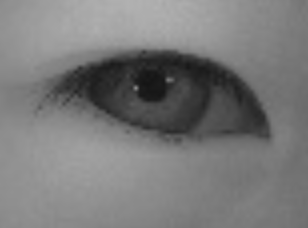

img_h:


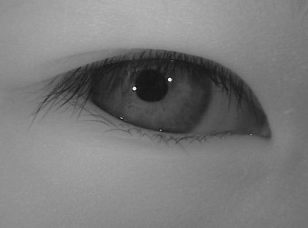

img_sr:


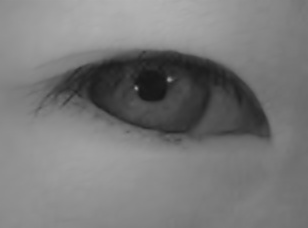

casia _train
im_l_upscaled:


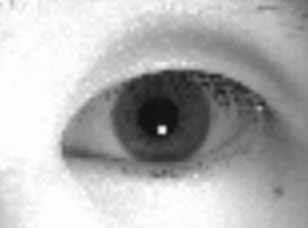

img_h:


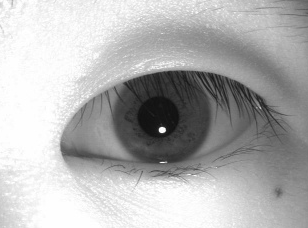

img_sr:


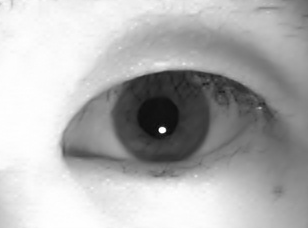

berc _train
im_l_upscaled:


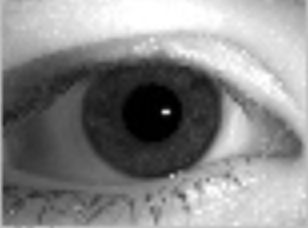

img_h:


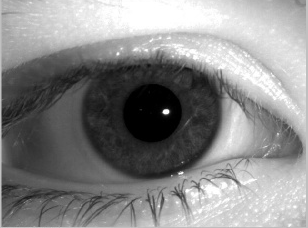

img_sr:


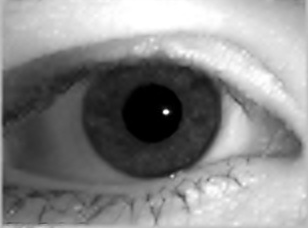

ndcld _train
im_l_upscaled:


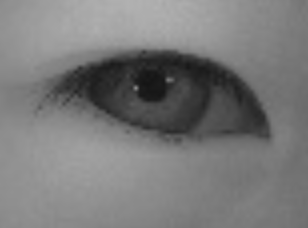

img_h:


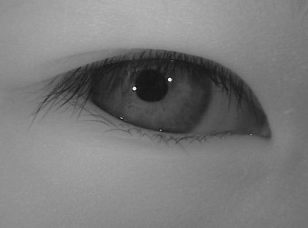

img_sr:


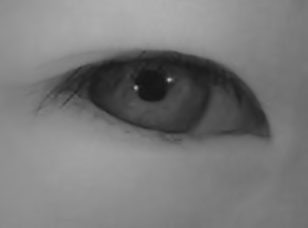

combined _train


In [37]:
# run statistis on all *Train* dataset and save log file
_imgNameLow_Dir = '/content/low_res_casia_train/'
_imgNameHigh_Dir = '/content/high_res_casia_train/'
_imgNameSR_Dir  = '/content/low_res_casia_train/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"casia_train")
print('casia _train')

_imgNameLow_Dir = '/content/low_res_berc_train/'
_imgNameHigh_Dir = '/content/high_res_berc_train/'
_imgNameSR_Dir  = '/content/low_res_berc_train/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"berc_train")
print('berc _train')

_imgNameLow_Dir = '/content/low_res_ndcld_train/'
_imgNameHigh_Dir = '/content/high_res_ndcld_train/'
_imgNameSR_Dir  = '/content/low_res_ndcld_train/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"ndcld_train")
print('ndcld _train')

_imgNameLow_Dir = '/content/low_res_combined_train/'
_imgNameHigh_Dir = '/content/high_res_combined_train/'
_imgNameSR_Dir  = '/content/low_res_combined_train/SR/'
print_error_statistics(_imgNameLow_Dir,_imgNameHigh_Dir,_imgNameSR_Dir,"combined_train")
print('combined _train')

**TODO:**
change to 1 dimension only (greyscale)
run on original dataset images small vs big - split dataset again *italicized text*